In [26]:
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm
from collections import defaultdict

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


# Данные

In [17]:
df = pd.read_csv(f'/content/train.csv')
print(df.shape)
df.head()

(15000, 24)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,35.0,175.0,75.0,86.5,1.2,1.2,1.0,1.0,127.0,...,58.0,108.0,15.6,1.0,0.9,17.0,14.0,21.0,0.0,0.0
1,1,45.0,155.0,60.0,82.0,1.2,1.0,1.0,1.0,129.0,...,50.0,110.0,14.0,1.0,0.7,22.0,18.0,14.0,0.0,0.0
2,2,35.0,175.0,60.0,74.0,1.2,1.2,1.0,1.0,100.0,...,58.0,116.0,14.8,1.0,0.9,20.0,15.0,16.0,0.0,1.0
3,3,60.0,160.0,55.0,74.0,1.2,1.5,1.0,1.0,139.0,...,73.0,95.0,15.1,1.0,0.7,47.0,31.0,15.0,0.0,0.0
4,4,40.0,160.0,55.0,71.0,0.9,1.2,1.0,1.0,100.0,...,66.0,103.0,13.1,1.0,0.6,24.0,21.0,13.0,0.0,0.0


In [18]:
df['smoking'].value_counts()

,count
smoking,
0.0,9443
1.0,5557


In [19]:
X, y = df.drop(['smoking', 'id'], axis=1), df['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((9000, 22), (3000, 22), (3000, 22))

# Обертки для данных

In [47]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X.values)
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [21]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Модель

In [27]:
class TorchModel_BN_Dropout_1(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(TorchModel_BN_Dropout_1, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            if i == 0:
              layers.append(nn.Dropout(p=0.1))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [68]:
class TorchModel_BN_Dropout_2(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(TorchModel_BN_Dropout_2, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            if i != 0:
              layers.append(nn.Dropout(p=0.1))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [73]:
class TorchModel_BN_Dropout_3(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(TorchModel_BN_Dropout_3, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            if i != 0:
              layers.append(nn.Dropout(p=0.2))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

# Train/eval loops

In [40]:
def train_model(model, num_epochs=100, eval_freq=10):
  train_loss_history, eval_loss_history = [], []
  train_rocauc_history, eval_rocauc_history = [], []
  global_step = 0

  model.train()
  for epoch in tqdm(range(num_epochs)):
      for batch_X, target in train_dataloader:
        optimizer.zero_grad()
        log_probs = model(batch_X.to(device))
        loss = loss_function(log_probs, target.to(device))
        loss.backward()
        optimizer.step()

        # preds = (log_probs >= 0.5).int().cpu().tolist()
        # f1 = f1_score(preds, target.cpu().numpy().tolist())
        y_score = log_probs.cpu().detach().numpy().tolist()
        y_true = target.cpu().numpy().tolist()
        rocauc = roc_auc_score(y_score=y_score, y_true=y_true)

        train_loss_history.append((global_step, loss.item()))
        train_rocauc_history.append((global_step, rocauc))

        if global_step % eval_freq == 0:
              val_loss, val_rocauc = evaluate(model)
              eval_loss_history.append((global_step, val_loss))
              eval_rocauc_history.append((global_step, val_rocauc))
              model.train()

        if global_step % 250 == 0:
              clear_output(True)

              plt.figure(figsize=(15, 5))

              plt.subplot(121)
              plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
              if len(eval_loss_history):
                  plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
              plt.legend()

              plt.subplot(122)
              plt.plot(*zip(*train_rocauc_history), alpha=0.5, label='train_rocauc')
              if len(eval_rocauc_history):
                  plt.plot(*zip(*eval_rocauc_history), color='red', label='eval_rocauc')
              plt.legend()
              plt.show()
        global_step += 1

  return model

In [61]:
@torch.no_grad()
def evaluate(model, mode='eval'):
    model.eval()

    # dataloader = val_dataloader if mode == 'eval' else test_dataloader
    if mode == 'eval':
      dataloader = val_dataloader
    elif mode == 'test':
      dataloader = test_dataloader
    elif mode == 'submit':
      dataloader = test_dataloader_sub

    loss_epoch = 0.
    num_epoch = 0.
    # preds_list = []
    y_score, targets_list = [], []

    for batch_X, target in dataloader:
      log_probs = model(batch_X.to(device))
      loss = loss_function(log_probs, target.to(device))
      num = log_probs.shape[0]
      loss_epoch += loss.item() * num
      num_epoch += num

      # preds_list += (log_probs >= 0.5).int().cpu().tolist()
      y_score += log_probs.cpu().detach().numpy().tolist()
      targets_list += target.cpu().numpy().tolist()

    if mode == 'submit':
      res_sub = pd.DataFrame(columns=['smoking'])
      y_score = [x for xs in y_score for x in xs]
      res_sub['smoking'] = y_score
      return res_sub

    rocauc = roc_auc_score(y_score=y_score, y_true=targets_list)

    return loss_epoch / num_epoch, rocauc

# Обучение модели 1

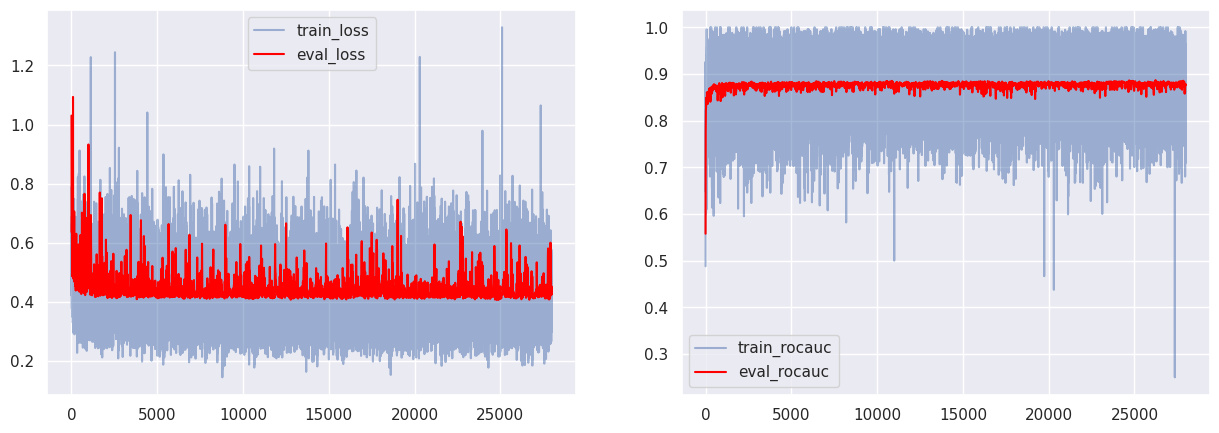

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TorchModel_BN_Dropout_1(1, 22, 22, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=100)

In [43]:
evaluate(model, mode='test')

(0.410891597032547, 0.8789078188612568)

сабмит:

In [44]:
df_test_sub = pd.read_csv(f'/content/test.csv')
print(df_test_sub.shape)
df_test_sub.head()

(10000, 23)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,15000,25.0,165.0,65.0,85.0,1.2,1.2,1.0,1.0,128.0,...,92.0,41.0,132.0,15.0,1.0,1.1,34.0,23.0,14.0,0.0
1,15001,45.0,165.0,60.0,74.0,1.5,1.0,1.0,1.0,104.0,...,124.0,54.0,129.0,11.3,1.0,0.7,20.0,17.0,11.0,0.0
2,15002,65.0,155.0,55.0,72.0,0.8,0.6,1.0,1.0,130.0,...,103.0,76.0,128.0,14.4,1.0,0.8,38.0,18.0,24.0,1.0
3,15003,30.0,170.0,85.0,88.0,0.7,0.9,1.0,1.0,119.0,...,212.0,44.0,117.0,14.8,1.0,1.1,26.0,38.0,19.0,0.0
4,15004,40.0,155.0,50.0,70.0,0.9,0.8,1.0,1.0,102.0,...,87.0,68.0,130.0,13.3,1.0,0.9,18.0,12.0,14.0,0.0


In [51]:
X = df_test_sub.drop(['id'], axis=1)
y = pd.Series(1, index=range(10000))

test_dataset_sub = CustomDataset(X, y)
test_dataloader_sub = DataLoader(test_dataset_sub, batch_size=32, shuffle=False)

In [65]:
res_sub = evaluate(model, mode='submit')
res_sub = pd.merge(df_test_sub['id'], res_sub, left_index=True, right_index=True)
display(res_sub)
res_sub.to_csv('submission1.csv', index=False)

,id,smoking
0,15000,0.243501
1,15001,0.001258
2,15002,0.174171
3,15003,0.426928
4,15004,0.018157
...,...,...
9995,24995,0.563260
9996,24996,0.047946
9997,24997,0.618287
9998,24998,0.354905


# Обучение модели 2

Применяем Dropout в других слоях модели

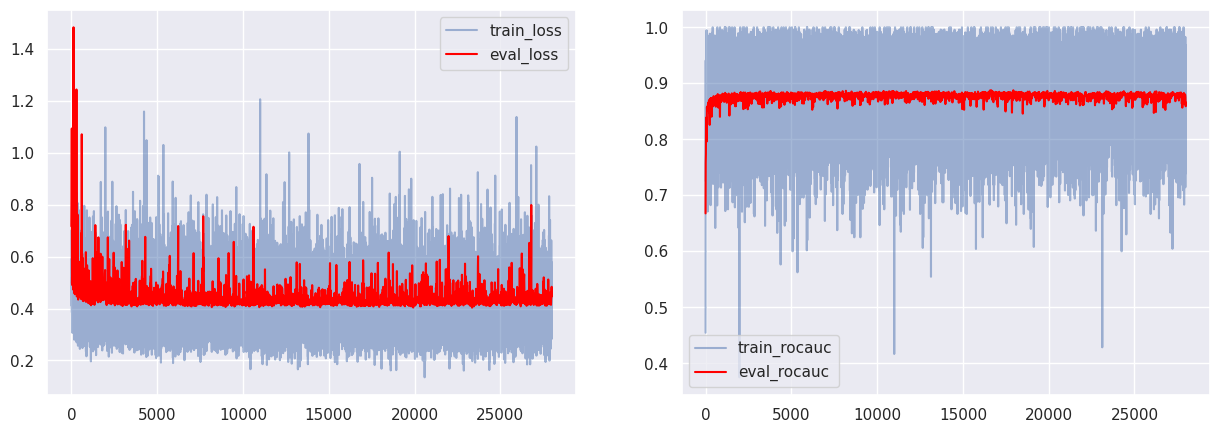

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TorchModel_BN_Dropout_2(1, 22, 22, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=100)

In [70]:
evaluate(model, mode='test')

(0.405666744073232, 0.8813493475328025)

сабмит:

In [71]:
res_sub = evaluate(model, mode='submit')
res_sub = pd.merge(df_test_sub['id'], res_sub, left_index=True, right_index=True)
display(res_sub)
res_sub.to_csv('submission2.csv', index=False)

,id,smoking
0,15000,0.293890
1,15001,0.015817
2,15002,0.044616
3,15003,0.553788
4,15004,0.003926
...,...,...
9995,24995,0.575881
9996,24996,0.017915
9997,24997,0.597192
9998,24998,0.250194


# Обучение модели 3

Применяем Dropout в других слоях модели + nn.Dropout, где p=0.2

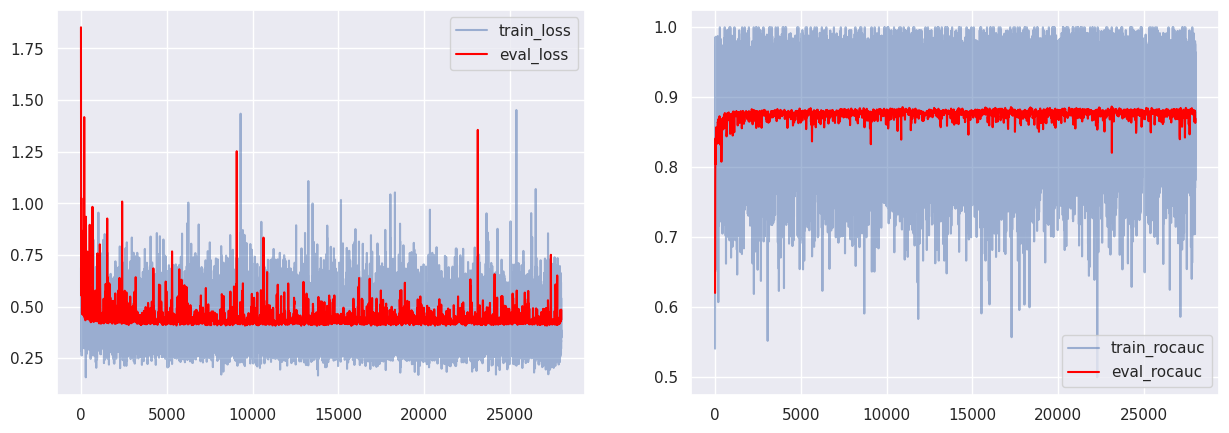

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TorchModel_BN_Dropout_3(1, 22, 22, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=100)

In [75]:
evaluate(model, mode='test')

(0.4231195513407389, 0.8795324681526763)

In [76]:
res_sub = evaluate(model, mode='submit')
res_sub = pd.merge(df_test_sub['id'], res_sub, left_index=True, right_index=True)
display(res_sub)
res_sub.to_csv('submission3.csv', index=False)

,id,smoking
0,15000,0.241634
1,15001,0.006337
2,15002,0.208394
3,15003,0.239917
4,15004,0.026318
...,...,...
9995,24995,0.515037
9996,24996,0.124996
9997,24997,0.513761
9998,24998,0.471912


# Обучение модели 4

То же самое что модель 1, только меньшее кол-во эпох

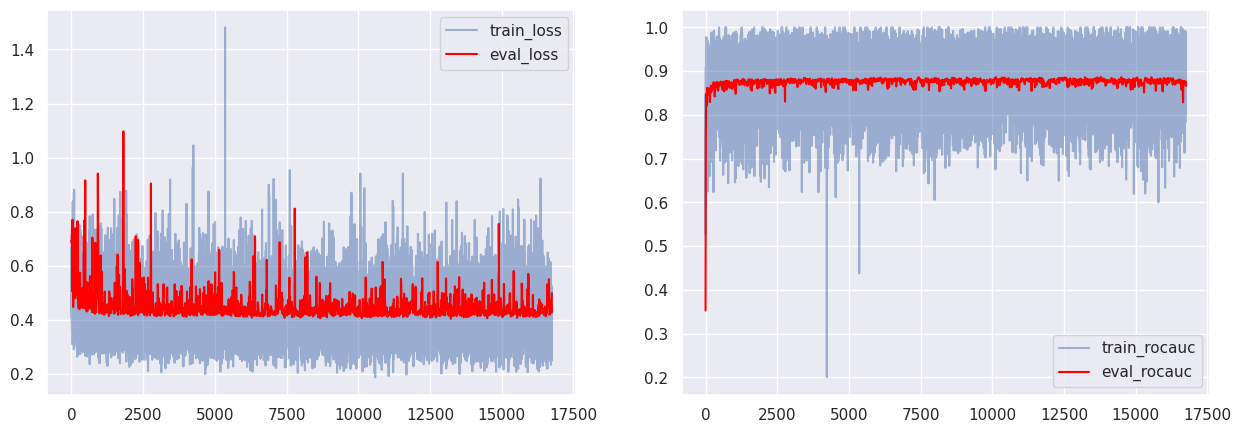

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TorchModel_BN_Dropout_1(1, 22, 22, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=60)

In [78]:
evaluate(model, mode='test')

(0.4051290147304535, 0.8825119688630475)

In [79]:
res_sub = evaluate(model, mode='submit')
res_sub = pd.merge(df_test_sub['id'], res_sub, left_index=True, right_index=True)
display(res_sub)
res_sub.to_csv('submission4.csv', index=False)

,id,smoking
0,15000,0.226413
1,15001,0.002796
2,15002,0.115147
3,15003,0.505841
4,15004,0.003182
...,...,...
9995,24995,0.663027
9996,24996,0.013999
9997,24997,0.589343
9998,24998,0.376244


**Итог:**

На kaggle лучший скор выбила модель 4 => лучшая модель - это модель 4.